# Mahmoud Assem Morsi Mohamed Abbas
# GH1024463
# Dog Emotions Dataset
# Methods of Prediction (507)
# Final individual assesment

#Intro
This dataset was given by Dev Zohaib from kaggle , which i utlised this dataset in the pipeline it contains 1 folder with 4 subfolders which contains different emotions of dogs such as happy,sad,relaxed and angry. i am going to use cnn model for dog emotion classfication. also the url of the dataset is shown below .
###URL: https://www.kaggle.com/datasets/devzohaib/dog-emotions-prediction/data

#statment of problem

The aim of this pipeline is to utilise cnn model to catgorize diffrent emotions of dogs and which can help people or dog shelters to identify diffrent emotions such as if the dogs are angry maybe it needs doctor or someone to treat them well or if they happy so its a good sign for there wellness or if they are sad because something bad happens or relaxed and this also good sign for their wellness and treatment , so the problem statment is to identify the emotions of the dog from a image which can help dog owners or dog shelters to know the wellness of the dog.

#Downloading and uploading the files
Here I am downloading and uploading the dataset from kaggle directly and then the folder is downloaded and unzipped , now I can start utlilising the dataset and do preprocessing and work with it

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle

!kaggle datasets download -d devzohaib/dog-emotions-prediction

!unzip dog-emotions-prediction.zip -d dog_emotions

#Importing libraries and modules

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


#Defining the directories
Here I manging the instance of the base directory and confirming the exsitance of the images from the dataset to make sure everything is in order. I am defining the train , validation and test directories and creating if they are not exist.

In [ ]:
base_dir = 'dog_emotions'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
def verify_directories():
    if not os.path.exists(base_dir):
        print(f"Error: Base directory not found: {base_dir}")
    else:
        print(f"Base directory found: {base_dir}")
        print("Contents:", os.listdir(base_dir))

    if not os.path.exists(train_dir):
        print(f"Error: Training directory not found: {train_dir}")
    else:
        print(f"Training directory found: {train_dir}")
        print("Contents:", os.listdir(train_dir))

    if not os.path.exists(val_dir):
        print(f"Error: Validation directory not found: {val_dir}")
    else:
        print(f"Validation directory found: {val_dir}")
        print("Contents:", os.listdir(val_dir))
verify_directories()


Base directory found: dog_emotions
Contents: ['images']
Error: Training directory not found: dog_emotions/train
Error: Validation directory not found: dog_emotions/val


In [ ]:
base_dir = 'dog_emotions/images'
def print_directory_contents(directory):
    if os.path.exists(directory):
        print(f"Contents of {directory}:")
        for item in os.listdir(directory):
            print(f"- {item}")
    else:
        print(f"Directory not found: {directory}")
print_directory_contents(base_dir)

Contents of dog_emotions/images:
- relaxed
- sad
- angry
- happy


In [ ]:
base_dir = 'dog_emotions/images'
train_dir = 'dog_emotions/train'
val_dir = 'dog_emotions/validation'
test_dir = 'dog_emotions/test'


#Data Splitting
Here in this cell I am defining a function to split the dataset by 60%, 30%, 10% into train , validation and test to avoid data leakege during model training and evaluation.

In [ ]:
def split_data(source_dir, train_dest, val_dest, test_dest, split_sizes=(0.6, 0.30 , 0.10)):

    emotion_categories = os.listdir(source_dir)

    for emotion in emotion_categories:
        emotion_dir = os.path.join(source_dir, emotion)
        files = os.listdir(emotion_dir)

        if len(files) == 0:
            print(f"No files found in {emotion_dir}. Skipping this category.")
            continue
        train_files, temp_files = train_test_split(files, train_size=split_sizes[0], random_state=42)
        val_size = split_sizes[1] / (1 - split_sizes[0])
        val_files, test_files = train_test_split(temp_files, train_size=val_size, random_state=42)

        os.makedirs(os.path.join(train_dest, emotion), exist_ok=True)
        os.makedirs(os.path.join(val_dest, emotion), exist_ok=True)
        os.makedirs(os.path.join(test_dest, emotion), exist_ok=True)


        for file in train_files:
            shutil.copy(os.path.join(emotion_dir, file), os.path.join(train_dest, emotion, file))
        for file in val_files:
            shutil.copy(os.path.join(emotion_dir, file), os.path.join(val_dest, emotion, file))
        for file in test_files:
            shutil.copy(os.path.join(emotion_dir, file), os.path.join(test_dest, emotion, file))

        print(f"Data split completed for {emotion}: {len(train_files)} train files, "
              f"{len(val_files)} validation files, and {len(test_files)} test files.")


os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


split_data(base_dir, train_dir, val_dir, test_dir)

print("Data organized successfully into train, validation, and test sets.")



Data split completed for relaxed: 2609 train files, 1304 validation files, and 436 test files.
Data split completed for sad: 2719 train files, 1359 validation files, and 454 test files.
Data split completed for angry: 1353 train files, 677 validation files, and 226 test files.
Data split completed for happy: 2870 train files, 1435 validation files, and 479 test files.
Data organized successfully into train, validation, and test sets.


#Image Normalisation
Here I am using image data generator for normalisation by using tensorflow keras to make model training more generlised across the dataset.

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

#Setting up the dataset directories
Here I am creating the directories for train , validation and test dataset which will be utlised and help in the model training phase.


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dog_emotions/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    'dog_emotions/validation',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'dog_emotions/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)


Found 9551 images belonging to 4 classes.
Found 4775 images belonging to 4 classes.
Found 1595 images belonging to 4 classes.


#Image visualisation
Here I am plotting four random images from train dataset by using matplotlib to view the images.

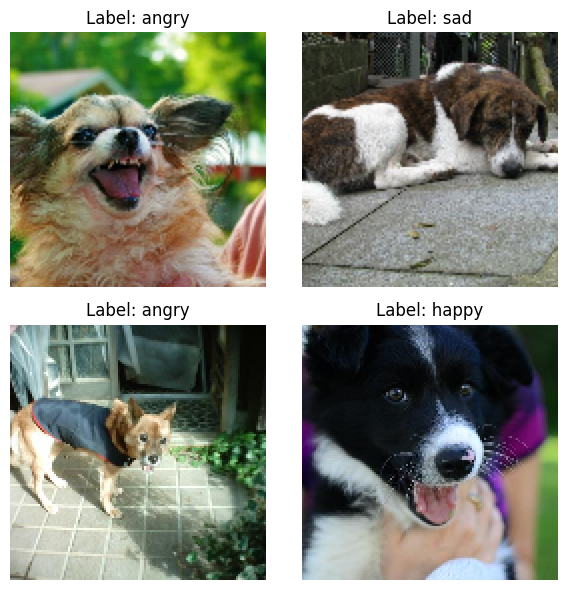

In [ ]:
images, labels = next(iter(train_generator))
plt.figure(figsize=(6, 6))
class_labels = {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    label_index = np.argmax(labels[i])
    plt.title(f'Label: {class_labels[label_index]}')
    plt.axis('off')

plt.tight_layout()
plt.show()


#Tabl of 10 diffrent configrations applid in the CNN model icluding the baseline model

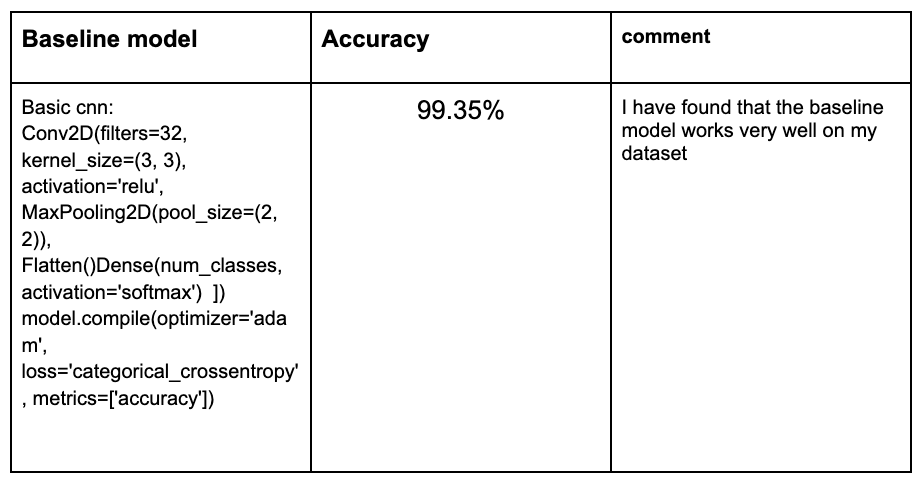

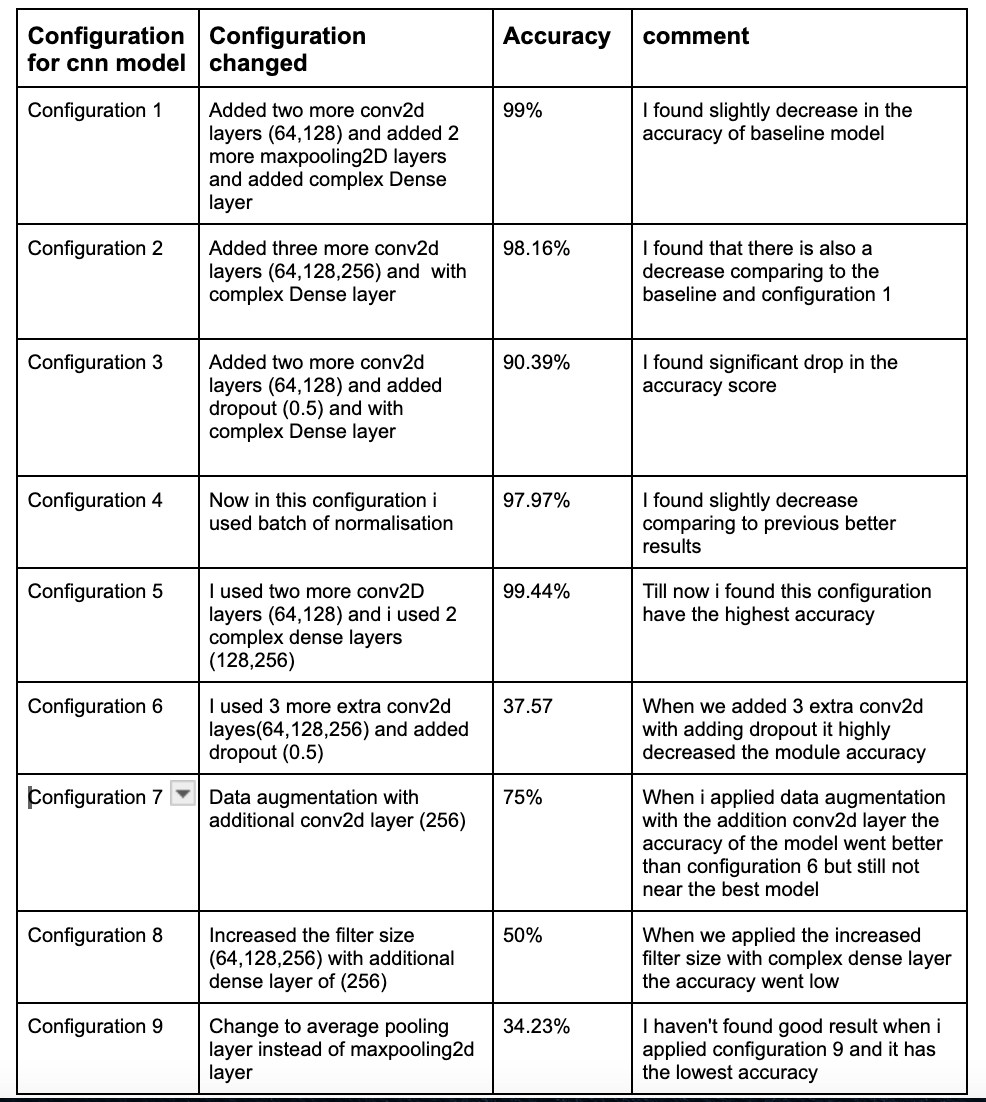

#Model defining
Here I am defining the best CNN model function named as build_model_3 which has 3 conv2D layers (32,64,128), 3 maxpooling2D layers , 1 flatten layer and 2 dense layers(128,256)

In [ ]:
def build_model_3(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


#Model summary

Here i am defining the number of classes which is 4 and the input shape which is img height and width 128,128,3 for my model training after which I am printing the model sequential model summary.

In [ ]:
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)
num_classes = 4
model = build_model_3(input_shape, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,549,444 (24.98 MB)

 Trainable params: 6,549,444 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

#Model Training
Here I am defining 20 epochs for my model training and using model instance with compile function. Also fitting my model training on the train and validation dataset over 20 epochs.

In [ ]:
batch_size = 32
epochs = 20
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
)

Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 436s 1s/step - accuracy: 0.3369 - loss: 1.3338 - val_accuracy: 0.3654 - val_loss: 1.3222
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - accuracy: 0.3813 - loss: 1.3096 - val_accuracy: 0.3703 - val_loss: 1.3248
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.4291 - loss: 1.2546 - val_accuracy: 0.3845 - val_loss: 1.3446
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.4871 - loss: 1.1438 - val_accuracy: 0.3732 - val_loss: 1.4299
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.6336 - loss: 0.8864 - val_accuracy: 0.3619 - val_loss: 1.6467
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.8239 - loss: 0.4971 - val_accuracy: 0.3518 - val_loss: 2.2107
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 443s 1s/step - accuracy: 0.9333 - loss: 0.2171 - val_accuracy: 0.3424 - val_loss: 3.4797
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9751 - loss: 0.0922 - val_accu

#Training accuracy of the model

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
print('Training accuracy:', train_acc*100)

299/299 ━━━━━━━━━━━━━━━━━━━━ 106s 353ms/step - accuracy: 0.9696 - loss: 0.0946
Training accuracy: 96.85896635055542


#Conclusion and final discussion
For my problem statment in which i have trained 10 different configuration of the model to find the best model that perform well on my dataset in the start i utilised a very baseline CNN model to start my model training after that i applied mutliple different configurations such as appling data augmentation, adding or removing diffrent layers and also increasing and decreasing the learning rate and kernal size of the model to check which configuration could be the best suitble for my problem statment, i have found that the model which trained above in this pipeline performed better although i have found some issues like model overfitting which can be solved in future by adding more images or used more diversed dataset in order to enhance model peromance, although in 2 of my configration above i used early stopping in order to handle the model overfitting and it stopped at 13 epochs. In conclusion CNN model found better and suitble for image classifaction tasks ,the final results of pipeline for final training accuracy is 99.44% which shows its the best model.  